A Dockerfile that will produce a container with all the dependencies necessary to run this notebook is available [here](https://github.com/AustinRochford/notebooks).

Clear the `theano` cache before each run to avoid subtle bugs.

In [1]:
!rm -rf /home/jovyan/.theano/

In [2]:
%matplotlib inline

In [3]:
import datetime
from itertools import product
import logging
import pickle
from warnings import filterwarnings

In [4]:
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from theano import shared, tensor as tt

In [5]:
# keep theano from complaining about compile locks for small models
(logging.getLogger('theano.gof.compilelock')
        .setLevel(logging.CRITICAL))

# silence PyMC3 warnings (there aren't many)
filterwarnings(
    'ignore', ".*diverging samples after tuning.*",
    module='pymc3'
)
filterwarnings(
    'ignore', ".*acceptance probability.*",
    module='pymc3'
)

In [6]:
pct_formatter = StrMethodFormatter('{x:.1%}')

blue, green, *_ = sns.color_palette()

# configure pyplot for readability when rendered as a slideshow and projected
sns.set(color_codes=True)

plt.rc('figure', figsize=(8, 6))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

In [7]:
SEED = 207183 # from random.org, for reproducibility

# Understanding NBA Foul Calls with Python

<table border="0">
    <tr>
        <td><img src="https://www.numfocus.org/wp-content/uploads/website.png" width=400></td>
        <td><img src="http://data-sports.abs-cbn.com/dev/media-upload/1499473043_nba-secondary-logo-small.jpg" width=400></td>
    </tr>
</table>


## PyData NYC &#8226; Nov 27, 2017 &#8226; [@AustinRochford](https://twitter.com/AustinRochford)

## About Me

<center><img src='http://austinrochford.com/resources/img/bball.jpg' width=300></center>

### Principal Data Scientist @ [Monetate Labs](http://www.monetate.com/) &#8226; PyMC3 contributor

### [@AustinRochford](https://twitter.com/AustinRochford) &#8226; [austinrochford.com](http://austinrochford.com) &#8226; [github.com/AustinRochford](http://github.com/AustinRochford)

### [austin.rochford@gmail.com](mailto:arochford@monetate.com) &#8226; [arochford@monetate.com](mailto:arochford@monetate.com)

## About this Talk

<hr style="height:5px; visibility:hidden;" />

<script src="https://gist.github.com/AustinRochford/0edef7cb3a8916fbe283188ee7df0923.js"></script>

# Last Two Minute Report

<center><img src="https://upload.wikimedia.org/wikipedia/commons/7/76/Kyrie_Irving_Free_Throw.jpg" width=700></center>

Since late in the 2014-2015 season, the NBA has issued [last two minute reports](http://official.nba.com/2017-18-nba-officiating-last-two-minute-reports/).  These reports give the league's assessment of the correctness of fall calls and non-calls in the last two minutes of any game where the score difference was three or fewer points at any point in the last two minutes.

These reports are notably different from play-by-play logs, in that they include information on non-calls for notable on-court interactions.  This non-call information presents a unique opportunity to study the factors that impact foul calls.  There is a level of subjectivity inherent in the the NBA's definition of notable on-court interactions which we attempt to mitigate later using season-specific factors.

### Scraping the data

<center><iframe src="https://pudding.cool/2017/02/two-minute-report/" height=400 width=600></iframe></center>

### Loading the data

We download the data locally to be kind to GitHub.

In [8]:
%%bash
DATA_URI=https://raw.githubusercontent.com/polygraph-cool/last-two-minute-report/32f1c43dfa06c2e7652cc51ea65758007f2a1a01/output/all_games.csv
DATA_DEST=/tmp/all_games.csv

if [[ ! -e $DATA_DEST ]];
then
    wget -q -O $DATA_DEST $DATA_URI
fi

We use only a subset of the columns in the source data set.

In [9]:
USECOLS = [
    'period',
    'seconds_left',
    'call_type',
    'committing_player',
    'disadvantaged_player',
    'review_decision',
    'play_id',
    'away',
    'home',
    'date',
    'score_away',
    'score_home',
    'disadvantaged_team',
    'committing_team'
]

In [10]:
orig_df = pd.read_csv(
    '/tmp/all_games.csv',
    usecols=USECOLS,
    index_col='play_id',
    parse_dates=['date']
)

In [11]:
orig_df.shape

(16300, 13)

The each row of the `DataFrame` represents a play and each column describes an attrbiute of the play:

* `period` is the period of the game,
* `seconds_left` is the number of seconds remaining in the game,
* `call_type` is the type of call
* `committing_player` and `disadvantaged_player` are the names of the players involved in the play,
* `review_decision` is the opinion of the league reviewer on whether or not the play was called correctly:
    * `review_decision = "INC"` means the call was an incorrect noncall,
    * `review_decision = "CNC"` means the call was an correct noncall,
    * `review_decision = "IC"` means the call was an incorrect call,
    * `review_decision = "CC"` means the call was an correct call,
* `away` and `home` are the abbreviations of the teams involved in the game,
* `date` is the date on which the game was played,
* `score_away` and `score_home` are the scores of the `away` and `home` team during the play, respectively,
* `disadvantaged_team` and `committing_team` indicate how each team is involved in the play.

In [12]:
orig_df.head(n=2).T

play_id,20150301CLEHOU-0,20150301CLEHOU-1
period,Q4,Q4
seconds_left,112,103
call_type,Foul: Shooting,Foul: Shooting
committing_player,Josh Smith,J.R. Smith
disadvantaged_player,Kevin Love,James Harden
review_decision,CNC,CC
away,CLE,CLE
home,HOU,HOU
date,2015-03-01 00:00:00,2015-03-01 00:00:00
score_away,103,103


### Research questions

1. How does game context impact foul calls?
2. Is (not) committing and/or drawing fouls a measurable player skill?

## Exploratory Data Analysis

First we examine the types of calls present in the data set.

In [13]:
orig_df.call_type.value_counts()

Foul: Personal                       4736
Foul: Shooting                       4201
Foul: Offensive                      2846
Foul: Loose Ball                     1316
Turnover: Traveling                   779
Instant Replay: Support Ruling        607
Foul: Defense 3 Second                277
Instant Replay: Overturn Ruling       191
Foul: Personal Take                   172
Turnover: 3 Second Violation          139
Turnover: 24 Second Violation         126
Turnover: 5 Second Inbound             99
Stoppage: Out-of-Bounds                96
Violation: Lane                        84
Foul: Away from Play                   82
Violation: Defensive Goaltending       65
Turnover: Stepped out of Bounds        59
Violation: Kicked Ball                 58
Foul: Technical                        38
Turnover: Backcourt Turnover           33
Violation: Delay of Game               32
Turnover: Out of Bounds                29
Turnover: Offensive Goaltending        26
Other                             

The portion of `call_type` before the colon is the general category of the call.  We count the occurence of these categories below.

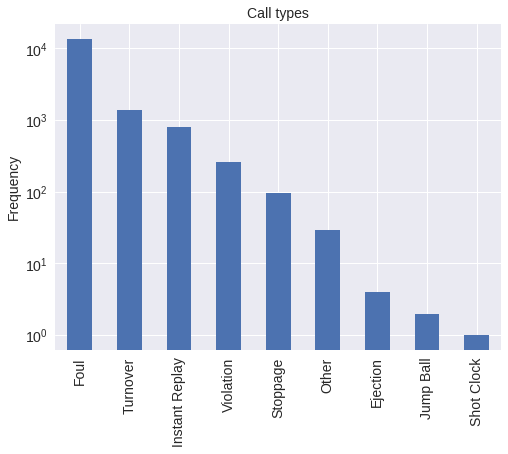

In [14]:
(orig_df.call_type
        .str.split(':', expand=True).iloc[:, 0]
        .value_counts()
        .plot(kind='bar', color=blue, logy=True, title="Call types")
        .set_ylabel("Frequency"));

We restrict our attention to foul calls, though other call types would be interesting to study in the future.

In [15]:
foul_df = orig_df[
    orig_df.call_type
           .fillna("UNKNOWN")
           .str.startswith("Foul")
]

We count the foul call types below.

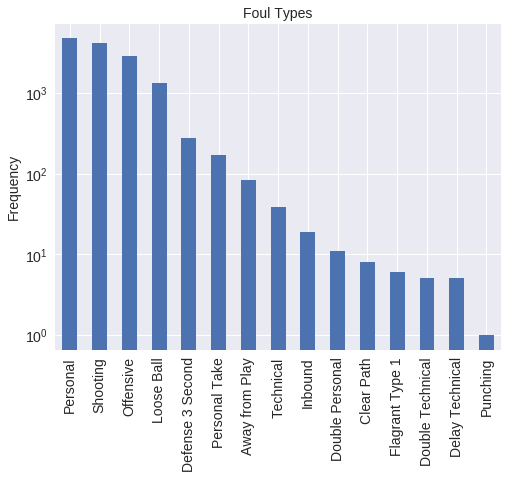

In [16]:
(foul_df.call_type
        .str.split(': ', expand=True).iloc[:, 1]
        .value_counts()
        .plot(kind='bar', color=blue, logy=True, title="Foul Types")
        .set_ylabel("Frequency"));

We restrict our attention to the five foul types below, which generally involve two players.  This subset of fouls allows us to pursue our second research question in the most direct manner.

In [17]:
FOULS = [
    f"Foul: {foul_type}"
    for foul_type in [
        "Personal",
        "Shooting",
        "Offensive",
        "Loose Ball",
        "Away from Play"
    ]
]

### Data transformation

<center><img src="https://c1.staticflickr.com/5/4003/4633000725_8817dcedb9_b.jpg" width=400></center>

There are a number of misspelled team names in the data, which we correct.

In [18]:
TEAM_MAP = {
    "NKY": "NYK",
    "COS": "BOS",
    "SAT": "SAS",
    "CHi": "CHI",
    "LA)": "LAC",
    "AT)": "ATL",
    "ARL": "ATL"
}

def correct_team_name(col):
    def _correct_team_name(df):
        return df[col].apply(lambda team_name: TEAM_MAP.get(team_name, team_name))
    
    return _correct_team_name

We also convert each game date to NBA season.

In [19]:
def date_to_season(date):
    if date >= datetime.datetime(2017, 10, 17):
        return '2017-2018'
    elif date >= datetime.datetime(2016, 10, 25):
        return '2016-2017'
    elif date >= datetime.datetime(2015, 10, 27):
        return '2015-2016'
    else:
        return '2014-2015'

We clean the data by

* restricting to plays that occured during the last two minutes of regulation,
* imputing incorrect non-calls when `review_decision` is missing,
* correcting team names,
* converting game dates to seasons,
* restricting to the foul types discussed above,
* restricting to the plays that happened during the [2015-2016](https://en.wikipedia.org/wiki/2015%E2%80%9316_NBA_season) and [2016-2017](https://en.wikipedia.org/wiki/2016%E2%80%9317_NBA_season) regular seasons (those are the only full seasons in the data set as of November 2017),
* and dropping unneeded rows and columns.

In [20]:
clean_df = (foul_df.where(lambda df: df.period == "Q4")
                   .where(lambda df: (df.date.between(datetime.datetime(2016, 10, 25),
                                                      datetime.datetime(2017, 4, 12))
                                     | df.date.between(datetime.datetime(2015, 10, 27),
                                                       datetime.datetime(2016, 5, 30)))
                         )
                   .assign(
                       review_decision=lambda df: df.review_decision.fillna("INC"),
                       committing_team=correct_team_name('committing_team'),
                       disadvantged_team=correct_team_name('disadvantaged_team'),
                       away=correct_team_name('away'),
                       home=correct_team_name('home'),
                       season=lambda df: df.date.apply(date_to_season)
                    )
                   .where(lambda df: df.call_type.isin(FOULS))
                   .dropna()
                   .drop('period', axis=1)
                   .assign(call_type=lambda df: (df.call_type
                                                   .str.split(': ', expand=True)  
                                                   .iloc[:, 1])))

About 50% of the rows in the full data set remain.

In [21]:
clean_df.shape[0] / orig_df.shape[0]

0.5516564417177914

In [22]:
clean_df.head(n=2).T

play_id,20151028INDTOR-1,20151028INDTOR-2
seconds_left,89,73
call_type,Shooting,Shooting
committing_player,Ian Mahinmi,Bismack Biyombo
disadvantaged_player,DeMar DeRozan,Paul George
review_decision,CC,IC
away,IND,IND
home,TOR,TOR
date,2015-10-28 00:00:00,2015-10-28 00:00:00
score_away,99,99
score_home,106,106


We use `scikit-learn`'s [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to transform categorical features (call type, player, and season) to integer ids.

In [23]:
call_type_enc = LabelEncoder().fit(
    clean_df.call_type
)
n_call_type = call_type_enc.classes_.size

player_enc = LabelEncoder().fit(
    np.concatenate((
        clean_df.committing_player,
        clean_df.disadvantaged_player
    ))
)
n_player = player_enc.classes_.size

season_enc = LabelEncoder().fit(
    clean_df.season
)
n_season = season_enc.classes_.size

We transform the data by

* rounding `seconds_left` to the nearest second (purely for convenience),
* transforming categorical features to integer ids,
* setting `foul_called` equal to zero if a foul was not called, or one if it was,
* setting `score_committing` and `score_disadvantaged` to the score of the committing and disadvantaged teams, respectively.

In [24]:
df = (clean_df[['seconds_left']]
              .round(0)
              .assign(
                call_type=call_type_enc.transform(clean_df.call_type),
                foul_called=1. * clean_df.review_decision.isin(['CC', 'INC']),
                player_committing=player_enc.transform(clean_df.committing_player),
                player_disadvantaged=player_enc.transform(clean_df.disadvantaged_player),
                score_committing=clean_df.score_home.where(
                    clean_df.committing_team == clean_df.home,
                    clean_df.score_away
                ),
                score_disadvantaged=clean_df.score_home.where(
                    clean_df.disadvantaged_team == clean_df.home,
                    clean_df.score_away
                ),
                season=season_enc.transform(clean_df.season)
              ))

The resulting `DataFrame` is ready for analysis.

In [25]:
df.head(n=2).T

play_id,20151028INDTOR-1,20151028INDTOR-2
seconds_left,89.0,73.0
call_type,4.0,4.0
foul_called,1.0,0.0
player_committing,162.0,36.0
player_disadvantaged,98.0,358.0
score_committing,99.0,106.0
score_disadvantaged,106.0,99.0
season,0.0,0.0


## Modeling

<table>
    <tr>
        <td>
            <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/GeorgeEPBox.jpg/1200px-GeorgeEPBox.jpg" width=300>
        </td>
        <td>
            George Box (via <a href="http://dustintran.com/talks/Tran_Edward.pdf">Dustin Tran</a>):
            <ol>
                <li>Build a model of the science</li>
                <li>Infer the model given data</li>
                <li>Criticize the model given data</li>
            </ol>
        </td>
    </tr>
</table>

### Build a model of the science

In [26]:
def make_foul_rate_yaxis(ax, label="Observed foul call rate"):
    ax.yaxis.set_major_formatter(pct_formatter)
    ax.set_ylabel(label)
    
    return ax

Below we examine the foul call rate by season.

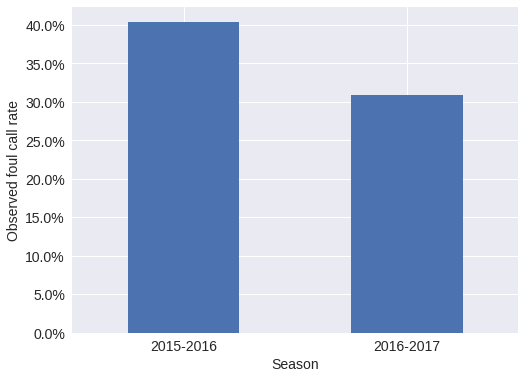

In [27]:
make_foul_rate_yaxis(
    df.pivot_table('foul_called', 'season')
      .rename(index=season_enc.inverse_transform)
      .rename_axis("Season")
      .plot(kind='bar', rot=0, legend=False)
);

There is a pronounced difference between the foul call rate in the 2015-2016 and 2016-2017 NBA seasons.  This change in foul call rates is due to a rule change between these seasons meant to [cut down on hack-a-Shaq](https://www.usatoday.com/story/sports/nba/2016/07/12/nba-approves-rule-changes-hack-a-shaq-situations/87013528/) fouls.

Our first model accounts for this difference.

* Each season has a different foul call rate

We use [`pymc3`](http://docs.pymc.io/) to specify our models.  Our first model is given by

$$
\begin{align*}
    \beta^{\textrm{season}}_s 
        & \sim N(0, 5) \\
    \eta^{\textrm{game}}_k
        & = \beta^{\textrm{season}}_{s(k)} \\
    p_k
        & = \textrm{sigm}\left(\eta^{\textrm{game}}_k\right).
\end{align*}
$$

We use a logistic regression model with different factors for each season.

In [28]:
import pymc3 as pm

with pm.Model() as base_model:
    β_season = pm.Normal('β_season', 0., 5., shape=n_season)
    p = pm.Deterministic('p', pm.math.sigmoid(β_season))

* Foul calls are like flipping a weighted coin

$$y_k \sim \textrm{Bernoulli}(p_k)$$

When building models, we will wrap each feature in a Theano [`shared`](http://deeplearning.net/software/theano/library/compile/shared.html) variable in order to eventually facilitate posterior predictive sampling.

In [29]:
season = shared(df.season.values)

In [30]:
with base_model:
    y = pm.Bernoulli(
        'y', p[season],
        observed=df.foul_called.values
    )

### Infer the model given data

<table>
    <tr>
        <td>
            <img src="https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg" width=400>
        </td>
        <td>
            <img src="https://i.pinimg.com/736x/ce/42/5c/ce425cdcb13afce4636d419f4ba786b0--stanislaw-ulam-richard-feynman.jpg" width=360>
        </td>
    </tr>
</table>

PyMC3 provides an accessible interface to state-of-the art Bayesian inference algorithms.  Throughout this talk, we will use PyMC3 to perform [Hamiltonian Monte Carlo inference](https://en.wikipedia.org/wiki/Hybrid_Monte_Carlo) (HMC).

Unfortunately there is not enough time in this talk to do these deep topics justice.  For the curious:

* [_Probabilistic Programming and 
Bayesian Methods for Hackers_](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers#pymc3) is an accessible, open-source introduction to Bayesian statistics using PyMC3.
* [_Statistical Rethinking_](http://xcelab.net/rm/statistical-rethinking/) is an acessible introduction to Bayesian data analysis originally using [Stan](http://mc-stan.org/), whose examples have been [ported to PyMC3](https://github.com/pymc-devs/resources/tree/master/Rethinking).
* [_Bayesian Analysis with Python_](https://www.amazon.com/Bayesian-Analysis-Python-Osvaldo-Martin/dp/1785883801) is an accessible introduction to Bayesian statistics using PyMC3.
* [_Bayesian Data Analysis_](http://www.stat.columbia.edu/~gelman/book/) (commonly known as BDA3) is an excellent reference on applied Bayesian statistics.
* [_A Conceptual Introduction to Hamiltonian Monte Carlo_](https://arxiv.org/abs/1701.02434) pairs an intuitive conceptual motivation of HMC algorithms with extensive references to the rigorous mathematics of HMC.
* [_The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo_](https://arxiv.org/abs/1111.4246) is the seminal paper on the NUTS algorithm that is central to modern Bayesian statistics.

In [31]:
NJOBS = 3

SAMPLE_KWARGS = {
    'draws': 1000,
    'njobs': NJOBS,
    'random_seed': [
        SEED + i for i in range(NJOBS)
    ]
}

In [32]:
with base_model:
    base_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:06<00:00, 235.48it/s]


#### Convergence diagnostics

> The folk theorem [of statistical computing] is this: When you have computational problems, often there’s a problem with your model.

&mdash; <a href="http://andrewgelman.com/2008/05/13/the_folk_theore/">Andrew Gelman</a>

We rely on three diagnostics to ensure that our samples have converged to the posterior distribution:

* Energy plots: if the two distributions in the energy plot differ significantly (espescially in the tails), the sampling was not very efficient.
* Bayesian fraction of missing information (BFMI): BFMI quantifies this difference with a number between zero and one. A BFMI close to (or exceeding) one is preferable, and a BFMI lower than 0.2 is indicative of efficiency issues.
* [Gelman-Rubin statistics](http://blog.stata.com/2016/05/26/gelman-rubin-convergence-diagnostic-using-multiple-chains/): Gelman-Rubin statistics near one are preferable, and values less than 1.1 are generally taken to indicate convergence.

For more information on energy plots and BFMI consult [_Robust Statistical Workflow with PyStan_](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html).

In [33]:
bfmi = pm.bfmi(base_trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(base_trace).values())

In [34]:
CONVERGENCE_TITLE = lambda: f"BFMI = {bfmi:.2f}\nGelman-Rubin = {max_gr:.3f}"

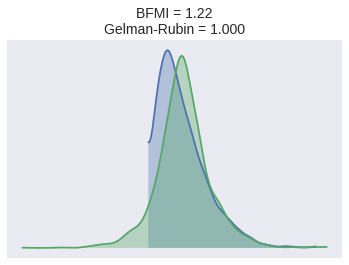

In [35]:
(pm.energyplot(base_trace, legend=False, figsize=(6, 4))
   .set_title(CONVERGENCE_TITLE()));

### Criticize the model given data

We use the samples from `p`'s posterior distribution to calculate [residuals](https://en.wikipedia.org/wiki/Errors_and_residuals), which we use to criticize our models.  These residuals allow us to assess how well our model describes the data-generation process and to discover unmodeled sources of variation. 

In [36]:
base_trace['p']

array([[ 0.39621111,  0.30601358],
       [ 0.40373111,  0.31909179],
       [ 0.40255341,  0.3074904 ],
       ..., 
       [ 0.40184561,  0.30958139],
       [ 0.40790953,  0.30464071],
       [ 0.39905963,  0.31899429]])

In [37]:
base_trace['p'].shape

(3000, 2)

In [38]:
resid_df = (df.assign(p_hat=base_trace['p'][:, df.season].mean(axis=0))
              .assign(resid=lambda df: df.foul_called - df.p_hat))

In [39]:
resid_df[['foul_called', 'p_hat', 'resid']].head()

,foul_called,p_hat,resid
play_id,,,
20151028INDTOR-1,1.0,0.403732,0.596268
20151028INDTOR-2,0.0,0.403732,-0.403732
20151028INDTOR-3,1.0,0.403732,0.596268
20151028INDTOR-4,0.0,0.403732,-0.403732
20151028INDTOR-6,0.0,0.403732,-0.403732


The per-season residuals are quite small, which is to be expected.

In [40]:
(resid_df.pivot_table('resid', 'season')
         .rename(index=season_enc.inverse_transform))

,resid
season,
2015-2016,-0.000019
2016-2017,0.000026


#### Intentional fouls

<hr style="height:5px; visibility:hidden;" />

<center>
<table>
    <tr>
        <td><img src="https://static1.squarespace.com/static/5150aec6e4b0e340ec52710a/t/51525c33e4b0b3e0d10f77ab/1364352052403/Data_Science_VD.png" width=400></td>
        <td><img src="https://sports.cbsimg.net/images/visual/whatshot/tdhugdj.jpg" width=500></td>
    </tr>
</table>
</center>

Anyone who has watched a close basketball game will realize that we have neglected an important factor in late game foul calls &mdash; [intentional fouls](https://en.wikipedia.org/wiki/Flagrant_foul#Game_tactics).  Near the end of the game, intentional fouls are used by the losing team when they are on defense to end the leading team's possession as quickly as possible.

The influence of intentional fouls in the plot below is shown by the rapidly increasing of the residuals as the number of seconds left in the game decreases.

In [41]:
def make_time_axes(ax,
                   xlabel="Seconds remaining in game",
                   ylabel="Observed foul call rate"):
    ax.invert_xaxis()
    ax.set_xlabel(xlabel)
    
    return make_foul_rate_yaxis(ax, label=ylabel)

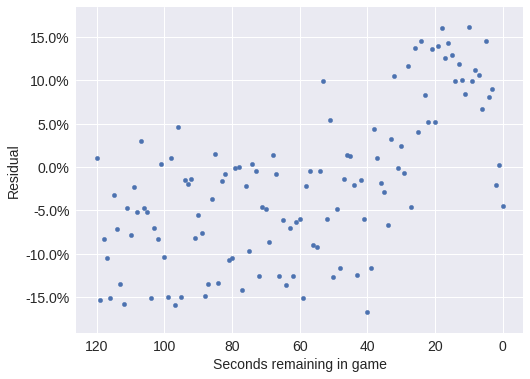

In [42]:
make_time_axes(
    resid_df.pivot_table('resid', 'seconds_left')
            .reset_index()
            .plot('seconds_left', 'resid', kind='scatter'),
    ylabel="Residual"
);

### Build a model of the science, take two

In [43]:
df['trailing_committing'] = (df.score_committing
                               .lt(df.score_disadvantaged)
                               .mul(1.)
                               .astype(np.int64))

The following plot illustrates the fact that only the trailing team has any incentive to committ intentional fouls.

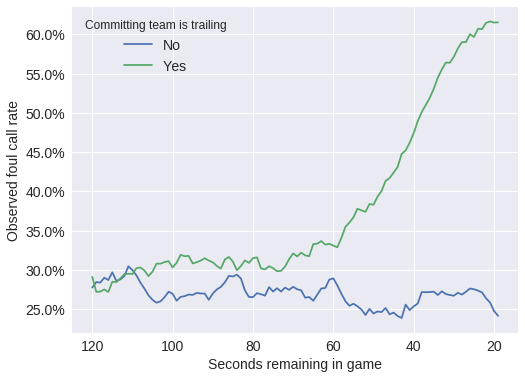

In [44]:
make_time_axes(
    df.pivot_table('foul_called', 'seconds_left', 'trailing_committing')
      .rolling(20).mean()
      .rename(columns={0: "No", 1: "Yes"})
      .rename_axis("Committing team is trailing", axis=1)
      .plot()
);

Intentional fouls are only useful when the trailing (and committing) team is on defense.  The plot below reflects this fact; shooting and personal fouls are almost always called against the defensive player; we see that they are called at a much higher rate than offensive fouls.

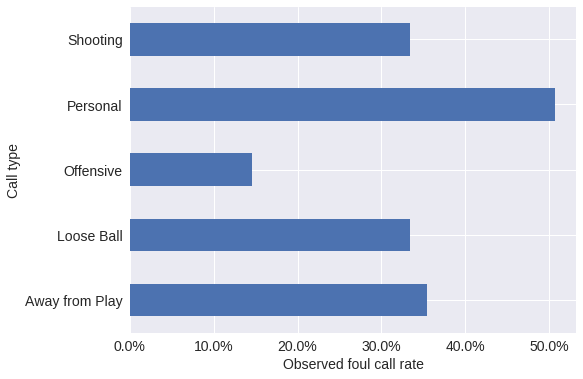

In [45]:
ax = (df.pivot_table('foul_called', 'call_type')
        .rename(index=call_type_enc.inverse_transform)
        .rename_axis("Call type", axis=0)
        .plot(kind='barh', legend=False))
ax.xaxis.set_major_formatter(pct_formatter);
ax.set_xlabel("Observed foul call rate");

We continue to model the differnce in foul call rates between seasons.

In [46]:
with pm.Model() as poss_model:
    β_season = pm.Normal('β_season', 0., 5., shape=2)

Throughout this talk, we will use [hierarchical distributions](https://en.wikipedia.org/wiki/Multilevel_model) to model the variation of foul call rates across different categories (in this instance, call types).  For much more information on hierarchical models, consult [_Data Analysis Using Regression and Multilevel/Hierarchical Models_](http://www.stat.columbia.edu/~gelman/arm/).

$$
\begin{align*}
    \sigma_{\textrm{call}}
        & \sim \operatorname{HalfNormal}(5) \\
    \beta^{\textrm{call}}_{c}
        & \sim \operatorname{Hierarchical-Normal}(0, \sigma_{\textrm{call}}^2)
\end{align*}
$$

For sampling efficiency, we use an [offset parametrization](http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/#The-Funnel-of-Hell-(and-how-to-escape-it)) of the hierarchical normal distribution.

In [47]:
def hierarchical_normal(name, shape, σ_shape=1):
    Δ = pm.Normal(
        f'Δ_{name}', 0., 1., shape=shape
    )
    σ = pm.HalfNormal(f'σ_{name}', 5., shape=σ_shape)
    
    return pm.Deterministic(name, Δ * σ)

* Each call type has a different foul call rate

In [48]:
with poss_model:
    β_call = hierarchical_normal('β_call', n_call_type)

We add score difference and the number of possessions by which the committing team is trailing to the `DataFrame`.  We assume that at most three points can be scored in a single possession (while this is not quite correct, [four-point plays](https://en.wikipedia.org/wiki/Four-point_play) are rare enough that we do not account for them in our analysis).

In [49]:
df['score_diff'] = (df.score_disadvantaged
                      .sub(df.score_committing))

df['trailing_poss'] = (df.score_diff
                         .div(3)
                         .apply(np.ceil))

In [50]:
trailing_poss_enc = LabelEncoder().fit(df.trailing_poss)
trailing_poss = shared(
    trailing_poss_enc.transform(df.trailing_poss)
)
n_trailing_poss = trailing_poss_enc.classes_.size

The plot below shows that the foul call rate (over time) varies based on the score difference (quantized into possessions) between the disadvanted team and the committing team.

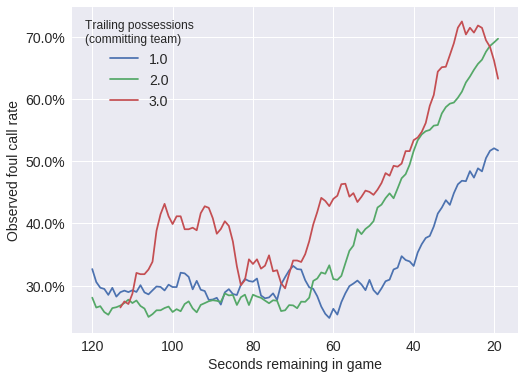

In [51]:
make_time_axes(
    df.pivot_table('foul_called', 'seconds_left', 'trailing_poss')
      .loc[:, 1:3]
      .rolling(20).mean()
      .rename_axis(
          "Trailing possessions\n(committing team)",
          axis=1
      )
      .plot()
);

The plot below reflects the fact that intentional fouls are disproportionately personal fouls; the rate at which personal fouls are called increases drastically as the game nears its end.

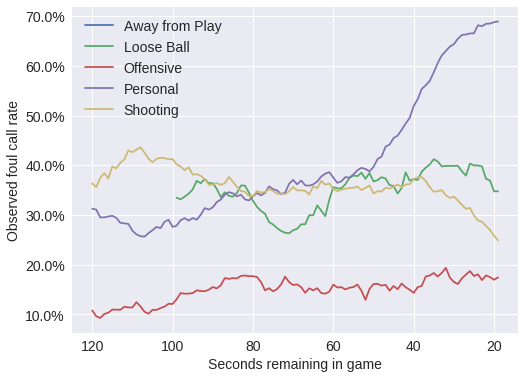

In [52]:
make_time_axes(
    df.pivot_table('foul_called', 'seconds_left', 'call_type')
      .rolling(20).mean()
      .rename(columns=call_type_enc.inverse_transform)
      .rename_axis(None, axis=1)
      .plot()
);

#### The shot clock

<center><img src="https://cdn-s3.si.com/s3fs-public/styles/marquee_large_2x/public/2017/08/22/nba-shot-clock-invention.jpg" width=700></center>

Due to the NBA's [shot clock](https://en.wikipedia.org/wiki/Shot_clock), the natural timescale of a basketball game is possessions, not seconds, remaining.

In [53]:
df['remaining_poss'] = (df.seconds_left
                          .floordiv(25)
                          .add(1))

In [54]:
remaining_poss_enc = LabelEncoder().fit(df.remaining_poss)
remaining_poss = shared(
    remaining_poss_enc.transform(df.remaining_poss)
)
n_remaining_poss = remaining_poss_enc.classes_.size

Below we plot the foul call rate across trailing possession/remaining posession pairs.  Note that we always calculate trailing possessions (`trailing_poss`) from the perspective of the committing team.  For instance, `trailing_poss = 1` indicates that the committing team is trailing by 1-3 points, whereas `trailing_poss = -1` indicates that the committing team is leading by 1-3 points.

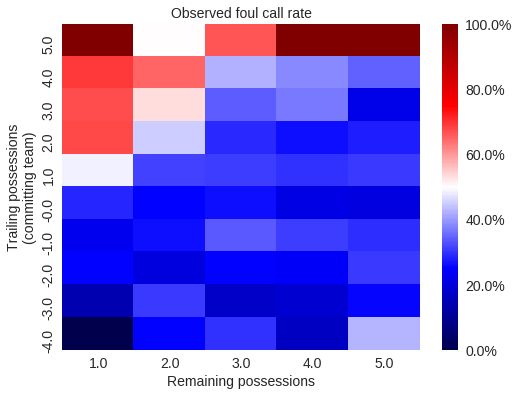

In [55]:
ax = sns.heatmap(
    df.pivot_table('foul_called', 'trailing_poss', 'remaining_poss')
      .rename_axis(
          "Trailing possessions\n(committing team)", axis=0
      )
      .rename_axis("Remaining possessions", axis=1),
    cmap='seismic', cbar_kws={'format': pct_formatter}
)
ax.invert_yaxis();
ax.set_title("Observed foul call rate");

The heatmap above shows that the foul call rate increases significantly when the committing team is trailing by more than the number of possessions remaining in the game.  That is, teams resort to intentional fouls only when the opposing team can run out the clock and guarantee a win.  (Since we have quantized the score difference and time into posessions, this conclusion is not entirely correct; it is, however, correct enough for our purposes.)

In [56]:
def plot_foul_diff_heatmap(*_, data=None, **kwargs):
    ax = plt.gca()

    sns.heatmap(
        data.pivot_table(
            'diff',
            'trailing_poss',
            'remaining_poss'
        ),
        cmap='seismic', robust=True,
        cbar_kws={'format': pct_formatter}
    )
    
    ax.invert_yaxis()
    ax.set_title("Observed foul call rate")

In [57]:
call_name_df = df.assign(
    call_type=lambda df: call_type_enc.inverse_transform(
        df.call_type.values
    )
)

diff_df = (pd.merge(
                call_name_df,
                call_name_df.groupby('call_type')
                         .foul_called.mean()
                         .rename('avg_foul_called')
                         .reset_index()
             )
             .assign(diff=lambda df: df.foul_called - df.avg_foul_called))

#### Difference from call type average

The heatmaps below are broken out by call type, and show the difference between the foul call rate for each trailing/remaining possession combination and the overall foul call rate for the call type in question

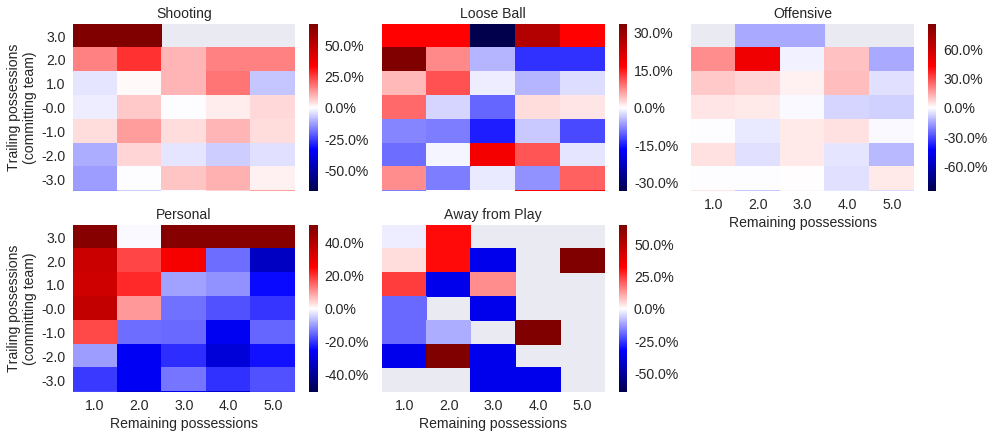

In [58]:
(sns.FacetGrid(diff_df, col='call_type', col_wrap=3, aspect=1.5)
    .map_dataframe(plot_foul_diff_heatmap)
    .set_axis_labels(
        "Remaining possessions",
        "Trailing possessions\n(committing team)"
    )
    .set_titles("{col_name}"));

These plots confirm that most intentional fouls are personal fouls.  They also show that the three-way interaction between trailing possesions, remaining possessions, and call type are important to model foul call rates.

* The foul call rate changes based on the number of possessions trailing and remaining and the call type

$$
\begin{align*}
    \sigma_{\textrm{poss}, c}
            & \sim \operatorname{HalfNormal}(5) \\
    \beta^{\textrm{poss}}_{t, r, c}
        & \sim \operatorname{Hierarchical-Normal}(0, \sigma_{\textrm{poss}, c}^2)
\end{align*}    
$$

In [59]:
with poss_model:
    β_poss = hierarchical_normal(
        'β_poss',
        (n_trailing_poss, n_remaining_poss, n_call_type),
        σ_shape=(1, 1, n_call_type)
    )

* The foul call rate is a combination of season, call type, and possession factors

$$\eta^{\textrm{game}}_k = \beta^{\textrm{season}}_{s(k)} + \beta^{\textrm{call}}_{c(k)} + \beta^{\textrm{poss}}_{t(k),r(k),c(k)}$$


In [60]:
call_type = shared(df.call_type.values)

In [61]:
with poss_model:
    η_game = β_season[season] \
                + β_call[call_type] \
                + β_poss[
                    trailing_poss, remaining_poss, call_type
                ]

$$
\begin{align*}
p_k
    & = \operatorname{sigm}\left(\eta^{\textrm{game}}_k\right)
\end{align*}
$$

In [62]:
with poss_model:
    p = pm.Deterministic('p', pm.math.sigmoid(η_game))
    y = pm.Bernoulli('y', p, observed=df.foul_called)

### Infer the model given data, take two

In [63]:
with poss_model:
    poss_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [06:34<00:00,  3.80it/s]


The BFMI and Gelman-Rubin statistics for this model indicate no problems with HMC sampling and good convergence.

In [64]:
bfmi = pm.bfmi(poss_trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(poss_trace).values())

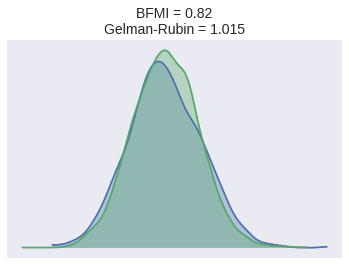

In [65]:
(pm.energyplot(poss_trace, legend=False, figsize=(6, 4))
   .set_title(CONVERGENCE_TITLE()));

### Criticize the model given data, take two

In [66]:
resid_df = (df.assign(p_hat=poss_trace['p'].mean(axis=0))
              .assign(resid=lambda df: df.foul_called - df.p_hat))

The following plots show that, grouped various ways, the residuals for this model are relatively well-distributed.

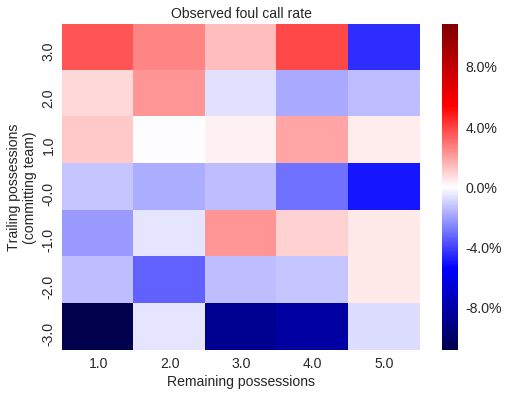

In [67]:
ax = sns.heatmap(
    resid_df.pivot_table('resid', 'trailing_poss', 'remaining_poss')
      .rename_axis("Trailing possessions\n(committing team)", axis=0)
      .rename_axis("Remaining possessions", axis=1)
      .loc[-3:3],
    cmap='seismic',  cbar_kws={'format': pct_formatter}
)
ax.invert_yaxis();
ax.set_title("Observed foul call rate");

In [68]:
N_BIN = 20

bin_ix, bins = pd.qcut(
    resid_df.p_hat, N_BIN,
    labels=np.arange(N_BIN),
    retbins=True
)

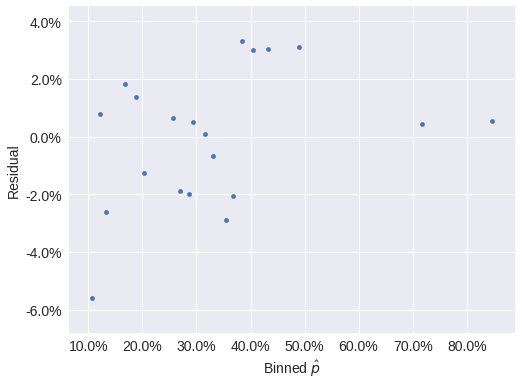

In [69]:
ax = (resid_df.groupby(bins[bin_ix])
              .resid.mean()
              .rename_axis('p_hat', axis=0)
              .reset_index()
              .plot('p_hat', 'resid', kind='scatter'))

ax.xaxis.set_major_formatter(pct_formatter);
ax.set_xlabel(r"Binned $\hat{p}$");

make_foul_rate_yaxis(ax, label="Residual");

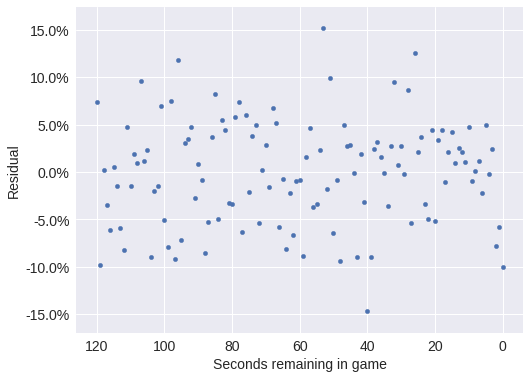

In [70]:
ax = (resid_df.groupby('seconds_left')
              .resid.mean()
              .reset_index()
              .plot('seconds_left', 'resid', kind='scatter'))
make_time_axes(ax, ylabel="Residual");

#### Model selection

Now that we have two models, we can engage in [model selection](https://en.wikipedia.org/wiki/Model_selection).  We use the [widely applicable Bayesian information criterion](http://www.jmlr.org/papers/volume14/watanabe13a/watanabe13a.pdf) ([WAIC](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf)) for model selection.

In [71]:
MODEL_NAME_MAP = {
    0: "Base",
    1: "Possession"
}

In [72]:
comp_df = (pm.compare(
                (base_trace, poss_trace),
                (base_model, poss_model)
             )
             .rename(index=MODEL_NAME_MAP)
             .loc[MODEL_NAME_MAP.values()])

Since smaller WAICs are better, the possession model clearly outperforms the base model.

In [73]:
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Base,11609.8,1.98,1543.34,0,56.98,73.35,1
Possession,10066.5,81.92,0,1,87.93,0,1


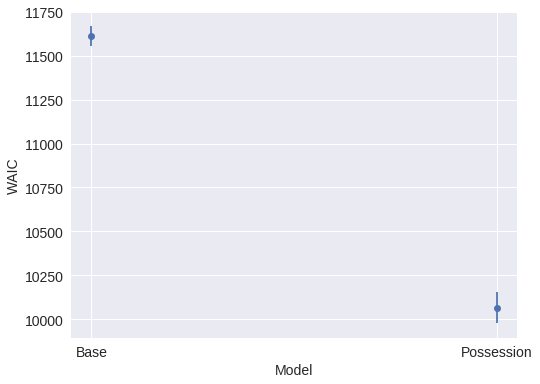

In [74]:
fig, ax = plt.subplots()
ax.errorbar(
    np.arange(len(MODEL_NAME_MAP)), comp_df.WAIC,
    yerr=comp_df.SE, fmt='o'
);
ax.set_xticks(np.arange(len(MODEL_NAME_MAP)));
ax.set_xticklabels(comp_df.index);
ax.set_xlabel("Model");
ax.set_ylabel("WAIC");

### Research questions

1. ~~How does game context impact foul calls?~~
2. Is (not) committing and/or drawing fouls a measurable player skill?

### Build a model of the science, take three

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/Graph_of_Bailey_Scores_of_Supreme_Court_Justices_1950-2011.png/800px-Graph_of_Bailey_Scores_of_Supreme_Court_Justices_1950-2011.png" width=650></center>

We now turn to the question of whether or not committing and/or drawing fouls is a measurable skill.  We use an [item-response theory](https://en.wikipedia.org/wiki/Item_response_theory) (IRT) model to study this question.

Unfortunately there is not enough time in this talk to do Bayesian item-response theory justice. For the curious:

* [_Practical Issues in Implementing and Understanding Bayesian Ideal Point Estimation_](http://www.stat.columbia.edu/~gelman/research/published/171.pdf) is an excellent introduction to applied Bayesian IRT models and has inspired much of this work.
* [_Bayesian Item Response Modeling &mdash; Theory and Applications_](http://www.springer.com/us/book/9781441907417) is a comprehensive mathematical overview of Bayesien IRT modeling.

#### Item-response theory

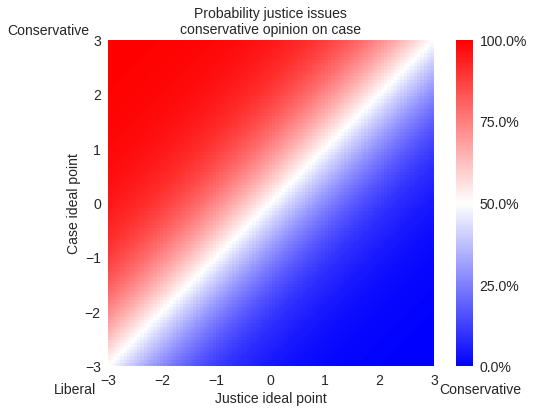

In [75]:
fig, ax = plt.subplots()
ax.set_aspect('equal');

x = y = np.linspace(-3, 3, 100)
C = sp.special.expit(
    np.subtract.outer(x, y)
)

poly = ax.pcolor(x, y, C, cmap='bwr')

ax.text(
    -4., -3.5, "Liberal",
    fontdict={'size': LABELSIZE}
);
ax.text(
    3.1, -3.5, "Conservative",
    fontdict={'size': LABELSIZE}
);
ax.text(
    -4.85, 3.1, "Conservative",
    fontdict={'size': LABELSIZE}
);

cbar = fig.colorbar(poly, ax=ax)
cbar.ax.yaxis.set_ticks(np.linspace(0, 1, 5));
cbar.ax.yaxis.set_major_formatter(pct_formatter);

ax.set_ylabel("Case ideal point");
ax.set_xlabel("Justice ideal point");
ax.set_title("Probability justice issues\nconservative opinion on case");

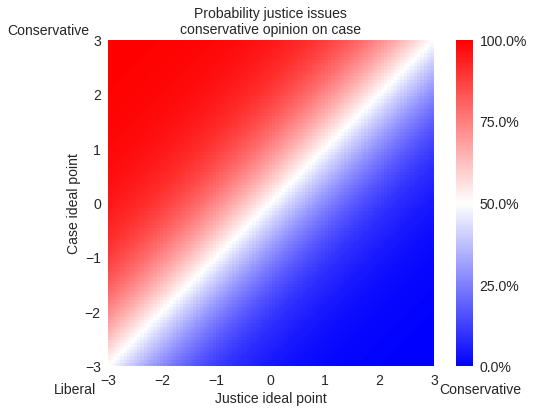

In [76]:
fig

In [77]:
with pm.Model() as irt_model:
    β_season = pm.Normal('β_season', 0., 5., shape=n_season)
    β_call = hierarchical_normal('β_call', n_call_type)
    β_poss = hierarchical_normal(
        'β_poss',
        (n_trailing_poss, n_remaining_poss, n_call_type),
        σ_shape=(1, 1, n_call_type)
    )
    
    η_game = β_season[season] \
                + β_call[call_type] \
                + β_poss[trailing_poss, remaining_poss, call_type]

In [78]:
player_committing = shared(df.player_committing.values)
player_disadvantaged = shared(df.player_disadvantaged.values)
n_player = player_enc.classes_.size

* Each disadvantaged player has an ideal point (per season)

$$
\begin{align*}
    \sigma_{\theta}
        & \sim \operatorname{HalfNormal}(5) \\
    \theta^{\textrm{player}}_{i, s}
        & \sim \operatorname{Hierarchical-Normal}(0, \sigma_{\theta}^2)
\end{align*}
$$

In [79]:
with irt_model:
    θ_player = hierarchical_normal(
        'θ_player', (n_player, n_season)
    )
    θ = θ_player[player_disadvantaged, season]

* Each committing player has an ideal point (per season)

$$
\begin{align*}
    \sigma_{b}
        & \sim \operatorname{HalfNormal}(5) \\
    b^{\textrm{player}}_{j, s}
        & \sim \operatorname{Hierarchical-Normal}(0, \sigma_{b}^2)
\end{align*}    
$$

In [80]:
with irt_model:
    b_player = hierarchical_normal(
        'b_player', (n_player, n_season)
    )
    b = b_player[player_committing, season]

* Players affect the foul call rate through the difference in their ideal points

$$\eta^{\textrm{player}}_k = \theta_k - b_k$$

In [81]:
with irt_model:
    η_player = θ - b

* Game and player effects combine to determine the foul call rate

$$\eta_k = \eta^{\textrm{game}}_k + \eta^{\textrm{player}}_k$$

In [82]:
with irt_model:
    η = η_game + η_player

In [83]:
with irt_model:
    p = pm.Deterministic('p', pm.math.sigmoid(η))
    y = pm.Bernoulli(
        'y', p,
        observed=df.foul_called
    )

### Infer the model given data, take three

In [84]:
with irt_model:
    irt_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [08:45<00:00,  2.85it/s]


In [85]:
bfmi = pm.bfmi(irt_trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(irt_trace).values())

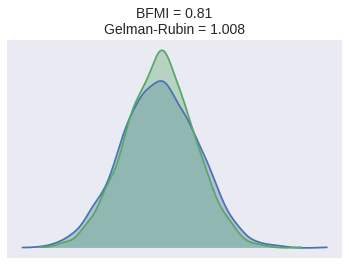

In [86]:
(pm.energyplot(irt_trace, legend=False, figsize=(6, 4))
   .set_title(CONVERGENCE_TITLE()));

### Criticize the model given data, take three

In [87]:
resid_df = (df.assign(p_hat=irt_trace['p'].mean(axis=0))
              .assign(resid=lambda df: df.foul_called - df.p_hat))

The binned residuals for this model are more asymmetric than for the previous models, but still not too bad.

In [88]:
N_BIN = 50

bin_ix, bins = pd.qcut(
    resid_df.p_hat, N_BIN,
    labels=np.arange(N_BIN),
    retbins=True
)

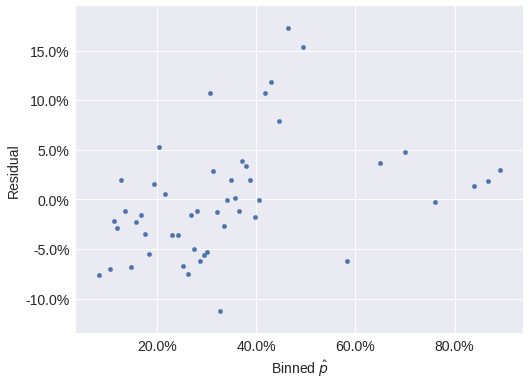

In [89]:
ax = (resid_df.groupby(bins[bin_ix])
              .resid.mean()
              .rename_axis('p_hat', axis=0)
              .reset_index()
              .plot('p_hat', 'resid', kind='scatter'))
ax.xaxis.set_major_formatter(pct_formatter);
ax.set_xlabel(r"Binned $\hat{p}$");
make_foul_rate_yaxis(ax, label="Residual");

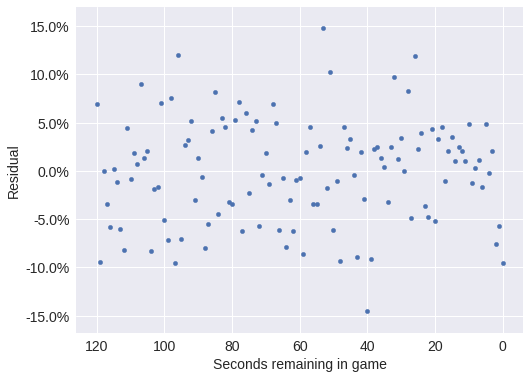

In [90]:
ax = (resid_df.groupby('seconds_left')
              .resid.mean()
              .reset_index()
              .plot('seconds_left', 'resid', kind='scatter'))
make_time_axes(ax, ylabel="Residual");

#### Model selection

The IRT model represents a marginal improvement over the possession model in terms of WAIC.

In [91]:
MODEL_NAME_MAP[2] = "IRT"

comp_df = (pm.compare(
                (base_trace, poss_trace, irt_trace),
                (base_model, poss_model, irt_model)
             )
             .rename(index=MODEL_NAME_MAP)
             .loc[MODEL_NAME_MAP.values()])

In [92]:
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Base,11609.8,1.98,1567.2,0,56.98,73.91,1
Possession,10066.5,81.92,23.86,0.1,87.93,10.98,1
IRT,10042.6,215.56,0,0.9,88.4,0,1


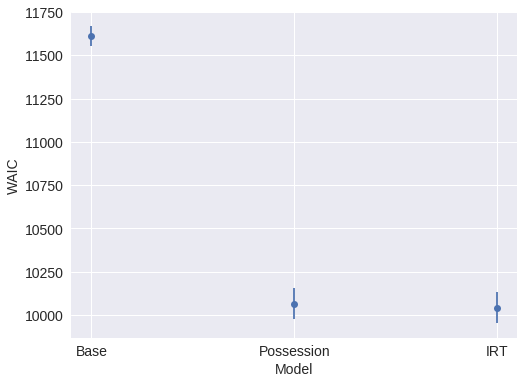

In [93]:
fig, ax = plt.subplots()
ax.errorbar(
    np.arange(len(MODEL_NAME_MAP)), comp_df.WAIC,
    yerr=comp_df.SE, fmt='o'
);
ax.set_xticks(np.arange(len(MODEL_NAME_MAP)));
ax.set_xticklabels(comp_df.index);
ax.set_xlabel("Model");
ax.set_ylabel("WAIC");

#### Is committing and/or drawing fouls a measurable player skill?

In [94]:
def varname_to_param(varname):
    return varname[0]

def varname_to_player(varname):
    return int(varname[3:-2])

def varname_to_season(varname):
    return int(varname[-1])

In [95]:
irt_df = (pm.trace_to_dataframe(
                irt_trace, varnames=['θ_player', 'b_player']
            )
            .rename(columns=lambda col: col.replace('_player', ''))
            .T
            .apply(
               lambda s: pd.Series.describe(
                   s, percentiles=[0.055, 0.945]
               ),
               axis=1
            )
            [['mean', '5.5%', '94.5%']]
            .rename(columns={
                 '5.5%': 'low',
                 '94.5%': 'high'
            })
            .rename_axis('varname')
            .reset_index()
            .assign(
                param=lambda df: df.varname.apply(varname_to_param),
                player=lambda df: df.varname.apply(varname_to_player),
                season=lambda df: df.varname.apply(varname_to_season)
            )
            .drop('varname', axis=1))

In [96]:
irt_df.head()

,mean,low,high,param,player,season
0,-0.015132,-0.312961,0.276028,θ,0,0
1,-0.003946,-0.284629,0.283364,θ,0,1
2,0.010513,-0.277971,0.290268,θ,1,0
3,0.037012,-0.239934,0.337692,θ,1,1
4,-0.034668,-0.311093,0.229465,θ,2,0


In [97]:
player_irt_df = irt_df.pivot_table(
    index='player',
    columns=['param', 'season'],
    values='mean'
)

In [98]:
player_irt_df.head()

param          b                   θ          
season         0         1         0         1
player                                        
0      -0.064689  0.006621 -0.015132 -0.003946
1      -0.006142  0.004387  0.010513  0.037012
2       0.090107  0.092868 -0.034668 -0.003519
3      -0.022949 -0.002456  0.005822 -0.003961
4      -0.006999  0.288897  0.068338  0.007508

The following plot shows that the committing skill appears to be somewhat larger than the disadvantaged skill.  This difference seems reasonable because most fouls are committed by the player on defense; committing skill is quite likely to to be correlated with defensive ability.

In [99]:
def plot_latent_params(df):
    fig, ax = plt.subplots()
    
    n, _ = df.shape
    y = np.arange(n)

    ax.errorbar(
        df['mean'], y,
        xerr=(df[['high', 'low']]
                .sub(df['mean'], axis=0)
                .abs()
                .values.T),
        fmt='o'
    )

    ax.set_yticks(y)
    ax.set_yticklabels(
        player_enc.inverse_transform(df.player)
    )
    ax.set_ylabel("Player")
    
    return fig, ax

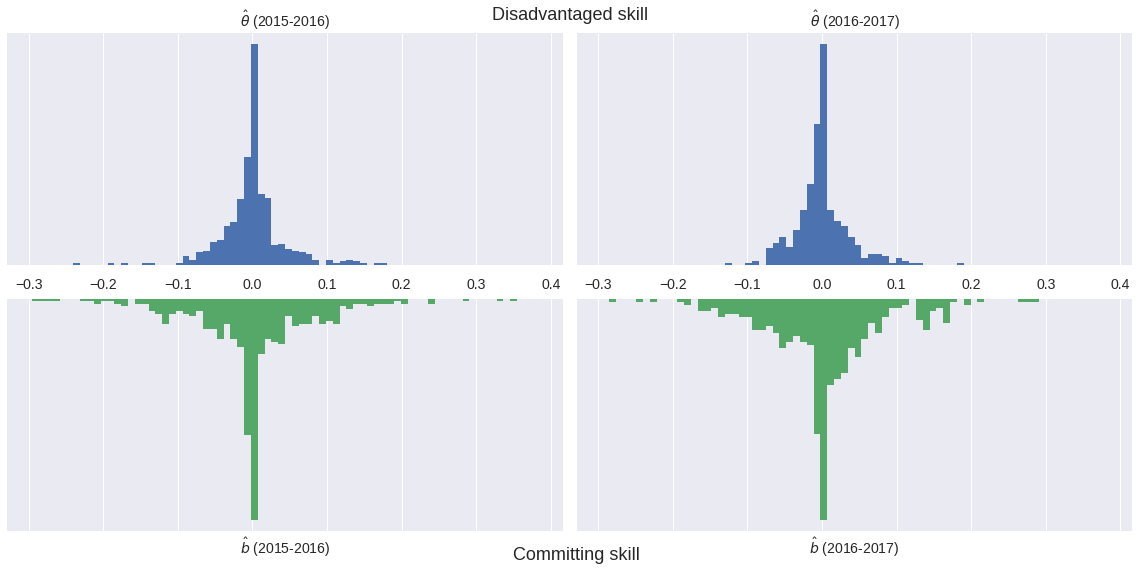

In [100]:
fig, axes = plt.subplots(
    ncols=2, nrows=2, sharex=True,
    figsize=(16, 8)
)
(θ0_ax, θ1_ax), (b0_ax, b1_ax) = axes

bins = np.linspace(
    0.9 * irt_df['mean'].min(),
    1.1 * irt_df['mean'].max(),
    75
)

θ0_ax.hist(
    player_irt_df['θ', 0],
    bins=bins, normed=True
);
θ1_ax.hist(
    player_irt_df['θ', 1],
    bins=bins, normed=True
);

θ0_ax.set_yticks([]);
θ0_ax.set_title(
    r"$\hat{\theta}$ (" + season_enc.inverse_transform(0) + ")"
);

θ1_ax.set_yticks([]);
θ1_ax.set_title(
    r"$\hat{\theta}$ (" + season_enc.inverse_transform(1) + ")"
);

b0_ax.hist(
    player_irt_df['b', 0],
    bins=bins, normed=True, color=green
);
b1_ax.hist(
    player_irt_df['b', 1],
    bins=bins, normed=True, color=green
);

b0_ax.set_xlabel(
    r"$\hat{b}$ (" + season_enc.inverse_transform(0) + ")"
);

b0_ax.invert_yaxis();
b0_ax.xaxis.tick_top();
b0_ax.set_yticks([]);

b1_ax.set_xlabel(
    r"$\hat{b}$ (" + season_enc.inverse_transform(1) + ")"
);

b1_ax.invert_yaxis();
b1_ax.xaxis.tick_top();
b1_ax.set_yticks([]);

fig.suptitle("Disadvantaged skill", size=18);
fig.text(0.45, 0.02, "Committing skill", size=18)
fig.tight_layout();

The latent ability parameters tend to lie in the interval $[-0.2, 0.2]$, so these skills are small, if they exist.

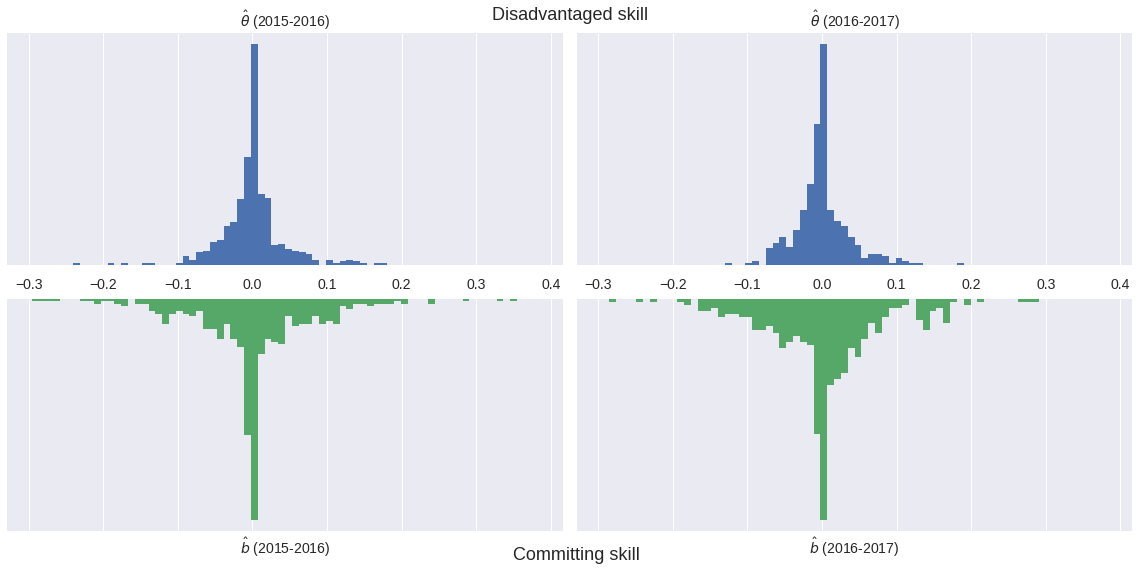

In [101]:
fig

In [102]:
top_bot_irt_df = (irt_df.groupby('param')
                    .apply(
                        lambda df: pd.concat((
                                df.nlargest(10, 'mean'),
                                df.nsmallest(10, 'mean')
                            ),
                            axis=0, ignore_index=True
                        )
                    )
                    .reset_index(drop=True))

In [103]:
top_bot_irt_df.head()

,mean,low,high,param,player,season
0,0.347551,-0.028239,0.758395,b,86,0
1,0.328016,-0.028768,0.707518,b,23,0
2,0.288897,-0.089046,0.677624,b,4,1
3,0.285537,-0.084353,0.689011,b,78,0
4,0.279316,-0.049866,0.634959,b,462,1


We now examine the top and bottom ten players in each ability, across both seasons.

The top players in terms of disadvantaged ability tend to be good scorers (Jimmy Butler, Ricky Rubio, John Wall, Andre Iguodala).  The presence of DeAndre Jordan in the top ten seems to be due to the hack-a-Shaq phenomenon.  Future work, it would be interesting to control for the disavantage player's free throw percentage in order to mitigate the influence of the hack-a-Shaq effect on the measurement of latent skill.

Interestingly, the bottom players (in terms of disadvantaged ability) include many stars (Pau Gasol, Carmelo Anthony, Kevin Durant, Kawhi Leonard).  The presence of these stars in the bottom may somewhat counteract the pervasive narrative that referees favor stars in their foul calls.

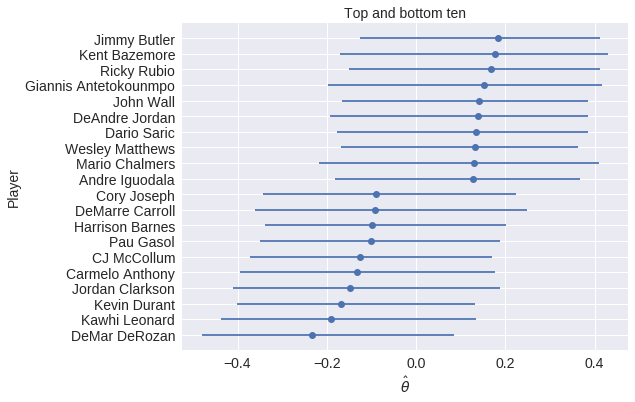

In [104]:
fig, ax = plot_latent_params(
    top_bot_irt_df[top_bot_irt_df.param == 'θ']
                  .sort_values('mean')
)
ax.set_xlabel(r"$\hat{\theta}$");
ax.set_title("Top and bottom ten");

The top ten players in terms of committing skill include many defensive standouts (Danny Green &mdash; twice, Gordon Hayward, Paul George).

The bottom ten players include many that are known to be defensively challenged (Ricky Rubio, James Harden, Chris Paul).  Dwight Howard was, at one point, a fierce defender of the rim, but was well past his prime in 2015, when our data set begins.

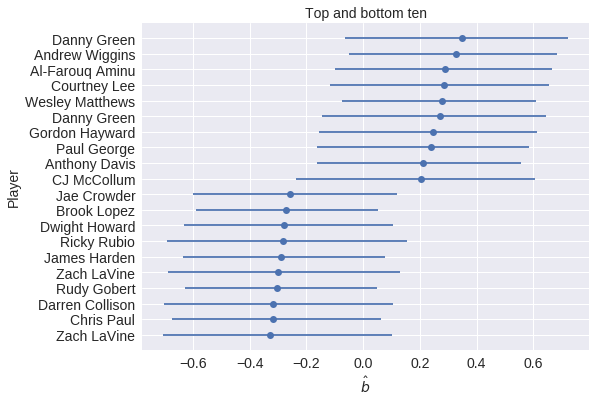

In [105]:
fig, ax = plot_latent_params(
    top_bot_irt_df[top_bot_irt_df.param == 'b']
                  .sort_values('mean')
)
ax.set_xlabel(r"$\hat{b}$");
ax.set_title("Top and bottom ten");

In [106]:
player_irt_df.head()

param          b                   θ          
season         0         1         0         1
player                                        
0      -0.064689  0.006621 -0.015132 -0.003946
1      -0.006142  0.004387  0.010513  0.037012
2       0.090107  0.092868 -0.034668 -0.003519
3      -0.022949 -0.002456  0.005822 -0.003961
4      -0.006999  0.288897  0.068338  0.007508

In [107]:
def p_val_to_asterisks(p_val):
    if p_val < 0.0001:
        return "****"
    elif p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    else:
        return ""

def plot_corr(x, y, **kwargs):
    corrcoeff, p_val = sp.stats.pearsonr(x, y)
    asterisks = p_val_to_asterisks(p_val)
    
    artist = AnchoredText(
        f'{corrcoeff:.2f}{asterisks}',
        loc=10, frameon=False,
        prop=dict(size=LABELSIZE)
    )
    plt.gca().add_artist(artist)
    plt.grid(b=False)

In [108]:
PARAM_MAP = {
    'θ': r"$\hat{\theta}$",
    'b': r"$\hat{b}$"
}

def replace_label(label):
    param, season = eval(label)

    return "{param}\n({season})".format(
        param=PARAM_MAP[param],
        season=season_enc.inverse_transform(season)
    )
    
def style_grid(grid):
    for ax in grid.axes.flat:
        ax.grid(False)
        ax.set_xticklabels([]);
        ax.set_yticklabels([]);
        
        if ax.get_xlabel():
            ax.set_xlabel(replace_label(ax.get_xlabel()))

        if ax.get_ylabel():
            ax.set_ylabel(replace_label(ax.get_ylabel()))
            
    return grid

In [109]:
player_all_season = set(df.groupby('player_disadvantaged')
                          .filter(lambda df: df.season.nunique() == n_season)
                          .player_committing) \
                        & set(df.groupby('player_committing')
                                .filter(lambda df: df.season.nunique() == n_season)
                                .player_committing)

##### Year-over-year consistency (players that appeared in all seasons)

In the sports analytics community, year-over-year correlation of latent parameters is the test of whether or not a skill exists.  The following plots show a slight (but significant) year-over-year correlation in the committing skill, but not much correlation in the disadvantaged skill.

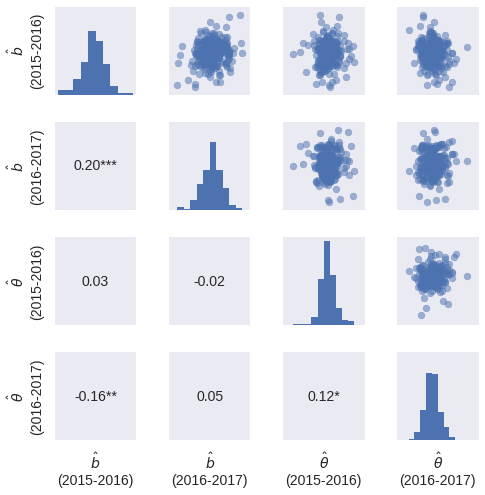

In [110]:
style_grid(sns.PairGrid(player_irt_df.loc[player_all_season], size=1.75)
              .map_upper(plt.scatter, alpha=0.5)
              .map_diag(plt.hist)
              .map_lower(plot_corr));

In [111]:
MIN = 10

player_has_min = set(df.groupby('player_disadvantaged')
                       .filter(lambda df: df.season.value_counts().gt(MIN).all())
                       .player_committing) \
                    & set(df.groupby('player_committing')
                            .filter(lambda df: df.season.value_counts().gt(MIN).all())
                            .player_committing)

##### Year-over-year consistency (players that appeared at least ten times in all seasons)

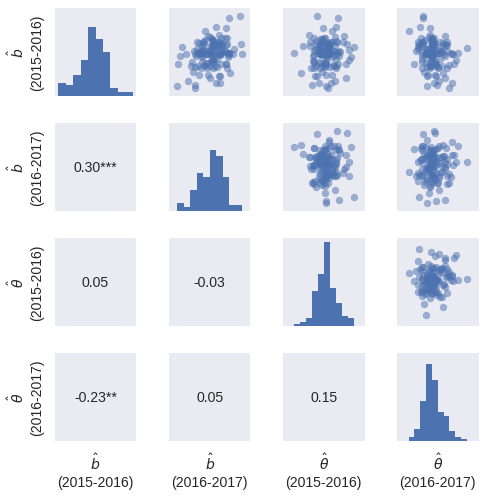

In [112]:
grid = style_grid(sns.PairGrid(player_irt_df.loc[player_has_min], size=1.75)
                     .map_upper(plt.scatter, alpha=0.5)
                     .map_diag(plt.hist)
                     .map_lower(plot_corr))

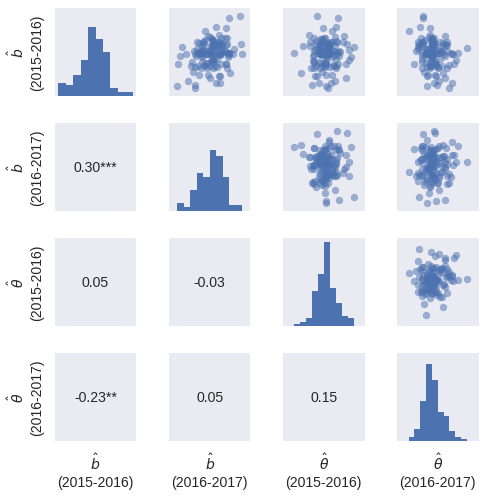

In [113]:
grid.fig

Based on this data set, disadvanted skill is not measurable, and if committing skill is measurable, its effect is quite small.

### Research questions

1. ~~How does game context impact foul calls?~~
2. ~~Is (not) committing and/or drawing fouls a measurable player skill?~~

## Visualize the Predictions

<hr style="height:5px; visibility:hidden;" />

<center><td><img src="https://cdn.rawgit.com/plotly/dash-docs/b1178b4e/images/dash-logo-stripe.svg"></td></center>

This section could be better documented, but I ran out of time.

In [114]:
with open('./irt.pickle', mode='wb') as dest:
    pickle.dump(
        {
            'call_type_enc': call_type_enc,
            'player_enc': player_enc,
            'season_enc': season_enc,
            'trailing_poss_enc': trailing_poss_enc,
            'remaining_poss_enc': remaining_poss_enc,
            'df': df,
            'irt_trace': irt_trace
        },
        dest
    )

In [115]:
!ls -lh ./irt.pickle

-rw-r--r-- 1 jovyan users 318M Nov 26 14:00 ./irt.pickle


In [116]:
import dash
import dash_html_components as html

In [117]:
import dash_core_components as dcc
import plotly.graph_objs as go

In [118]:
CALL_TYPE = 0
PLAYER_COMMITTING = 0
PLAYER_DISADVANTAGED = 1
SEASON = 1

In [119]:
def get_pp_data_df(call_type=CALL_TYPE,
                   player_committing=PLAYER_COMMITTING,
                   player_disadvantaged=PLAYER_DISADVANTAGED,
                   season=SEASON):
    return (pd.DataFrame(
                list(product(
                    np.arange(n_trailing_poss),
                    np.arange(n_remaining_poss)
                )),
                columns=[
                    'trailing_poss',
                    'remaining_poss'
                ]
              )
              .assign(
                call_type=call_type,
                player_committing=player_committing,
                player_disadvantaged=1,
                season=SEASON
              ))

In [120]:
def get_irt_df(player_committing_=PLAYER_COMMITTING,
               player_disadvantaged_=PLAYER_DISADVANTAGED,
               season_=SEASON):
    return pd.DataFrame({
        'θ': irt_trace['θ_player'][:, player_disadvantaged_, season_],
        'b': irt_trace['b_player'][:, player_committing_, season_]
    })

In [121]:
def get_pp_df(call_type_=CALL_TYPE,
              player_committing_=PLAYER_COMMITTING,
              player_disadvantaged_=PLAYER_DISADVANTAGED,
              season_=SEASON):
    pp_data_df = get_pp_data_df(
        call_type=call_type_,
        player_committing=player_committing_,
        player_disadvantaged=player_disadvantaged_,
        season=season_
    )
    
    call_type.set_value(pp_data_df.call_type.values)
    player_committing.set_value(pp_data_df.player_committing.values)
    player_disadvantaged.set_value(pp_data_df.player_disadvantaged.values)
    season.set_value(pp_data_df.season.values)
    trailing_poss.set_value(pp_data_df.trailing_poss.values)
    remaining_poss.set_value(pp_data_df.remaining_poss.values)
    
    with irt_model:
        pp_trace = pm.sample_ppc(irt_trace)
        
    return pp_data_df.assign(
        p_hat=pp_trace['y'].mean(axis=0)
    )

In [122]:
def get_irt_scatter(irt_df):
    return {
        'data': [
            go.Scatter(
                x=irt_df.b,
                y=irt_df.θ,
                mode='markers',
                marker={'opacity': 0.5},
                hoverinfo='none'
            )
        ],
        'layout': go.Layout(
            title="Latent parameters",
            xaxis={'title': "b (committing player)"},
            yaxis={'title': "θ (disadvantaged player)"}
        )
    }

In [123]:
def get_irt_hist(irt_df):
    return {
        'data': [
            go.Histogram(
                x=irt_df.θ - irt_df.b,
                histnorm='probability',
                hoverinfo='none'
            )
        ],
        'layout': go.Layout(
            title="Latent parameter difference",
            xaxis={'title': "η_game"}
        )
    }

In [124]:
def get_foul_figure(pp_df):
    table = pp_df.pivot_table(
        'p_hat',
        'trailing_poss',
        'remaining_poss'
    )
    
    return {
        'data': [
            go.Heatmap(
                x=remaining_poss_enc.inverse_transform(
                    table.columns
                ),
                y=trailing_poss_enc.inverse_transform(
                    table.index
                ),
                z=table.values.tolist(),
                zmin=0., zmax=0.75,
                hoverinfo='z',
                colorbar={'tickformat': '.1%'}
            )
        ],
        'layout': go.Layout(
            title="Predicted foul call probability",
            xaxis={'title': "Remaining possessions"},
            yaxis={'title': "Trailing possessions"}
        )
    }

In [125]:
PLAYER_OPTIONS = [
    {
        'label': name,
        'value': i
    }
    for i, name in enumerate(player_enc.classes_)
]

In [126]:
INPUT_TABLE = html.Table(
    [
        html.Tr([
            html.Td(
                [
                    html.Div("Season"),
                    dcc.Dropdown(
                        id='season-dropdown',
                        options=[
                            {
                                'label': season,
                                'value': i
                            }
                            for i, season in enumerate(season_enc.classes_)
                        ],
                        value=0
                    )
                ],
                style={'width': '50%'}
            ),
            html.Td([
                html.Div("Call type"),
                dcc.Dropdown(
                    id='call-type-dropdown',
                    options=[
                        {
                            'label': call_type.lstrip("Foul: "),
                            'value': i
                        }
                        for i, call_type in enumerate(call_type_enc.classes_)
                    ],
                    value=0
                )
            ])
        ]),
        html.Tr([
            html.Td([
                    html.Div("Disadvantaged player"),
                    dcc.Dropdown(
                        id='player-disadvantaged-dropdown',
                        options=PLAYER_OPTIONS,
                        value=1
                    )
            ]),
            html.Td([
                    html.Div("Committing player"),
                    dcc.Dropdown(
                        id='player-committing-dropdown',
                        options=PLAYER_OPTIONS,
                        value=0
                    )
            ])
        ])
    ],
    style={'width': '100%'}
)

In [127]:
FOUL_HEATMAP = dcc.Graph(
    id='foul-heatmap',
    figure=get_foul_figure(
        get_pp_df()
    )
)

IRT_PARAM_SCATTER = dcc.Graph(
    id='irt-param-scatter',
    figure=get_irt_scatter(
        get_irt_df()
    )
)

IRT_DIFF_HIST = dcc.Graph(
    id='irt-diff-hist',
    figure=get_irt_hist(
        get_irt_df()
    )
)

  0%|          | 0/1000 [00:00<?, ?it/s]


In [128]:
TABLE = html.Table(
    [
        html.Tr([
            html.Td(
                [INPUT_TABLE],
                style={'width': '50%'}
            ),
            html.Td([FOUL_HEATMAP])
        ]),
        html.Tr([
            html.Td([IRT_PARAM_SCATTER]),
            html.Td([IRT_DIFF_HIST])
        ])
    ],
    style={'width': '75%'}
)

In [129]:
app = dash.Dash()

app.layout = html.Div(children=[
    html.H1(
        "Understanding NBA Foul Calls with Python"
    ),
    html.Center(TABLE)
])

In [130]:
@app.callback(
    dash.dependencies.Output(
        'irt-param-scatter', 'figure'
    ),
    [
        dash.dependencies.Input(
            'season-dropdown','value'
        ),
        dash.dependencies.Input(
            'player-committing-dropdown','value'
        ),
        dash.dependencies.Input(
            'player-disadvantaged-dropdown','value'
        )
    ]
)
def update_irt_scatter(season_,
                       player_committing_,
                       player_disadvantaged_):
    irt_df = get_irt_df(
        player_committing_=player_committing_,
        player_disadvantaged_=player_disadvantaged_,
        season_=season_,
    )

    return get_irt_scatter(irt_df)

In [131]:
@app.callback(
    dash.dependencies.Output(
        'irt-diff-hist', 'figure'
    ),
    [
        dash.dependencies.Input(
            'season-dropdown','value'
        ),
        dash.dependencies.Input(
            'player-committing-dropdown','value'
        ),
        dash.dependencies.Input(
            'player-disadvantaged-dropdown','value'
        )
    ]
)
def update_irt_hist(season_,
                    player_committing_,
                    player_disadvantaged_):
    irt_df = get_irt_df(
        player_committing_=player_committing_,
        player_disadvantaged_=player_disadvantaged_,
        season_=season_,
    )

    return get_irt_hist(irt_df)

@app.callback(
    dash.dependencies.Output('foul-heatmap', 'figure'),
    [
        dash.dependencies.Input(
            'call-type-dropdown','value'
        ),
        dash.dependencies.Input(
            'season-dropdown','value'
        ),
        dash.dependencies.Input(
            'player-committing-dropdown','value'
        ),
        dash.dependencies.Input(
            'player-disadvantaged-dropdown','value'
        )
    ]
)
def update_foul_pct_graph(call_type_,
                          season_,
                          player_committing_,
                          player_disadvantaged_):
    pp_df = get_pp_df(
        call_type_=call_type_,
        player_committing_=player_committing_,
        player_disadvantaged_=player_disadvantaged_,
        season_=season_
    )

    return get_foul_figure(pp_df)

In [132]:
app.css.config.serve_locally = True
app.scripts.config.serve_locally = True
app.run_server(host='0.0.0.0')

 * Running on http://0.0.0.0:8050/ (Press CTRL+C to quit)
172.17.0.1 - - [26/Nov/2017 14:01:46] "GET / HTTP/1.1" 200 -
172.17.0.1 - - [26/Nov/2017 14:01:46] "GET /_dash-component-suites/dash_renderer/react@15.4.2.min.js?v=0.11.1 HTTP/1.1" 200 -
172.17.0.1 - - [26/Nov/2017 14:01:46] "GET /_dash-component-suites/dash_core_components/react-virtualized-select@3.1.0.css?v=0.15.0 HTTP/1.1" 200 -
172.17.0.1 - - [26/Nov/2017 14:01:46] "GET /_dash-component-suites/dash_core_components/react-dates@12.3.0.css?v=0.15.0 HTTP/1.1" 200 -
172.17.0.1 - - [26/Nov/2017 14:01:46] "GET /_dash-component-suites/dash_core_components/rc-slider@6.1.2.css?v=0.15.0 HTTP/1.1" 200 -
172.17.0.1 - - [26/Nov/2017 14:01:46] "GET /_dash-component-suites/dash_core_components/react-select@1.0.0-rc.3.min.css?v=0.15.0 HTTP/1.1" 200 -
172.17.0.1 - - [26/Nov/2017 14:01:46] "GET /_dash-component-suites/dash_core_components/react-virtualized@9.9.0.css?v=0.15.0 HTTP/1.1" 200 -
172.17.0.1 - - [26/Nov/2017 14:01:46] "GET /_dash-co

## Thank You!

<img src="https://media1.giphy.com/media/xIJLgO6rizUJi/giphy.gif">

### [@AustinRochford](https://twitter.com/AustinRochford) &#8226; [austinrochford.com](http://austinrochford.com) &#8226; [github.com/AustinRochford](http://github.com/AustinRochford)

### [austin.rochford@gmail.com](mailto:arochford@monetate.com) &#8226; [arochford@monetate.com](mailto:arochford@monetate.com)

The code in the following cell converts this notebook to an HTML slideshow powered by [reveal.js](http://lab.hakim.se/reveal-js/).

In [134]:
%%bash
jupyter nbconvert \
    --to=slides \
    --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ \
    --output=nba-fouls-pydata-nyc-2017 \
    ./PyData\ NYC\ 2017\ Understanding\ NBA\ Foul\ Calls\ with\ Python.ipynb

[NbConvertApp] Converting notebook ./PyData NYC 2017 Understanding NBA Foul Calls with Python.ipynb to slides
[NbConvertApp] Writing 1245540 bytes to ./nba-fouls-pydata-nyc-2017.slides.html
